### Written by Kevin Scaccia <kevin_developer@outlook.com>, Nov 2019

## Simple Dense Image Denoise Autoencoder - Keras API
### Two different train methodologies - Test on MNIST Dataset


### Imports 

In [0]:
import numpy as np  # matrix math
import matplotlib.pyplot as plt  # plot library
import matplotlib.patches as mpatches  # legend on plot
import pandas as pd  # load dataset
from sklearn import datasets  # example dataset
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.datasets import mnist
plt.style.use('ggplot') # plot style

### Load and Preprocess Mnist dataset


train_x shape:  (60000, 784)
train_y shape:  (60000, 10) 



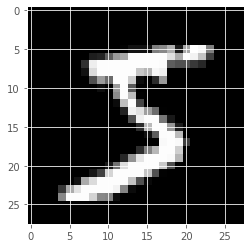

In [0]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Flatten x
train_x = x_train.reshape(x_train.shape[0], 28*28) / 255
test_x = x_test.reshape(x_test.shape[0], 28*28) / 255
# encode y
number_of_classes = 10
train_y = np.zeros( (y_train.shape[0], number_of_classes) )
test_y = np.zeros( (y_test.shape[0], number_of_classes) )
for i in range(len(train_y)):
    train_y[i][y_train[i]] = 1.0
for i in range(len(test_y)):
    test_y[i][y_test[i]] = 1.0
#
print('train_x shape: ', train_x.shape)
print('train_y shape: ', train_y.shape)
#
plt.imshow(train_x[0].reshape(28,28), cmap='gray')
plt.show()

### Define Dense Autoencoder

In [0]:
input_size = 28 * 28 # flatten image
output_size = 10 # number of digits
#
# Define Model
#
auto_encoder = Sequential()
# encoder
auto_encoder.add( keras.layers.Dense(input_size, activation=keras.activations.relu) )
auto_encoder.add( keras.layers.Dense(512, activation=keras.activations.relu) )
 # bottleneck
auto_encoder.add( keras.layers.Dense(256, activation=keras.activations.relu) ) 
# decoder
auto_encoder.add( keras.layers.Dense(512, activation=keras.activations.relu) ) 
auto_encoder.add( keras.layers.Dense(input_size, activation=keras.activations.relu) ) 
#
auto_encoder.compile(loss='mse', optimizer=keras.optimizers.adam(0.01),
    metrics=['accuracy'],)

#### Auxiliary Procedure to Insert Noise in images

In [0]:
def insert_noise_image(image, amount):
    # amount = percent of noise
    new_image = image.copy()
    amount = int( amount * image.shape[0])
    for i in range(amount):
        pixel_index = np.random.randint(low=0, high=image.shape[0], size=1) 
        new_image[pixel_index] = 0
    return new_image

### Auxiliary Procedure to see the model in Action


In [0]:
# n: how many digits we will display
# noise_rate: 
def validate_model(model, test_x, n, noise_rate=0.1):  
    samples, reconstructions = [], []
    #
    for i in range(n):
        sample = insert_noise_image(test_x[i], noise_rate)
        samples.append(sample)
        rec = model.predict(np.array([sample,]))
        reconstructions.append(rec)
    #
    # Plot Noised Images 
    #
    print("Noised Images - noise_rate =", noise_rate)
    plt.figure(figsize=(18, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.show()
    #
    # Plot Reconstruction
    #
    print("\nAutoencoder Reconstruction")
    plt.figure(figsize=(18, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.show()

### Train Model (First methodology)
#### Input and Output are the same original images (without noise)



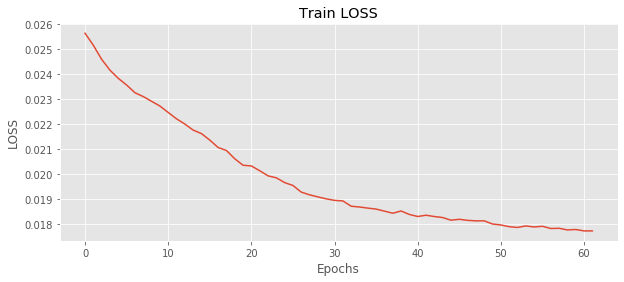

In [0]:
train_split = 60000 # train over 60000 examples
epochs = 200 # 200 epochs limit
# early stop callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
    min_delta=0.001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
#
history = auto_encoder.fit(train_x[:train_split], train_x[:train_split], 
    batch_size=1000, epochs=epochs, verbose=1, validation_split=0.2, callbacks=[early_stopping])
#
plt.figure(figsize=(10,4)); plt.title("Train LOSS"); plt.xlabel("Epochs"); plt.ylabel("LOSS")
plt.plot(history.history['loss'][10:]); plt.show()

#### Model Validation

Noised Images - noise_rate = 0.98


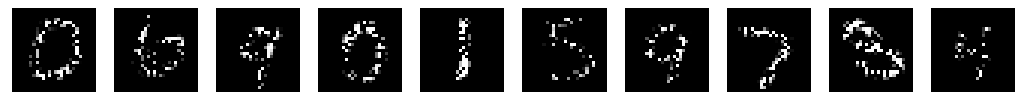


Autoencoder Reconstruction


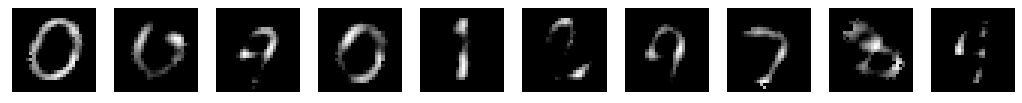

In [0]:
validate_model(auto_encoder, test_x[10:], 10, noise_rate=0.98)

### Train Model (Second methodology)
#### Input are noised images and Output are the original corresponding images (without noise)
We will train the autoencoder to map noisy digits images to clean digits images.

48000/48000 [==============================] - 10s 201us/step - loss: 0.0250 - acc: 0.0115 - val_loss: 0.0252 - val_acc: 0.0109
Epoch 20/200
48000/48000 [==============================] - 10s 201us/step - loss: 0.0248 - acc: 0.0110 - val_loss: 0.0251 - val_acc: 0.0121
Epoch 21/200
48000/48000 [==============================] - 10s 200us/step - loss: 0.0247 - acc: 0.0115 - val_loss: 0.0250 - val_acc: 0.0110
Epoch 22/200
48000/48000 [==============================] - 10s 201us/step - loss: 0.0247 - acc: 0.0114 - val_loss: 0.0255 - val_acc: 0.0101
Epoch 23/200
48000/48000 [==============================] - 10s 201us/step - loss: 0.0247 - acc: 0.0111 - val_loss: 0.0251 - val_acc: 0.0092
Epoch 24/200
48000/48000 [==============================] - 10s 199us/step - loss: 0.0246 - acc: 0.0117 - val_loss: 0.0251 - val_acc: 0.0121
Epoch 25/200
48000/48000 [==============================] - 10s 200us/step - loss: 0.0246 - acc: 0.0111 - val_loss: 0.0249 - val_acc: 0.0117
Epoch 26/200
48000/48000 [

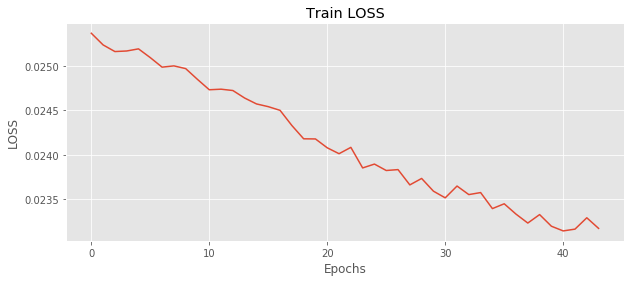

In [0]:
train_split = 60000 # train over 60000 examples
epochs = 200 # 200 epochs limit
noise_amount = 0.98
noised_input_train = np.array( [insert_noise_image(img, noise_amount) for img in train_x[:train_split]] )
# early stop callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
    min_delta=0.001, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
#
history = auto_encoder.fit(noised_input_train, train_x[:train_split], 
    batch_size=1000, epochs=epochs, verbose=1, validation_split=0.2, callbacks=[early_stopping])
#
plt.figure(figsize=(10,4)); plt.title("Train LOSS"); plt.xlabel("Epochs"); plt.ylabel("LOSS")
plt.plot(history.history['loss'][10:]); plt.show()

#### Model Validation

Noised Images - noise_rate = 2


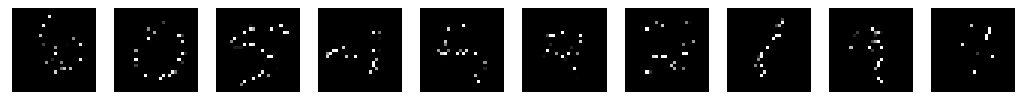


Autoencoder Reconstruction


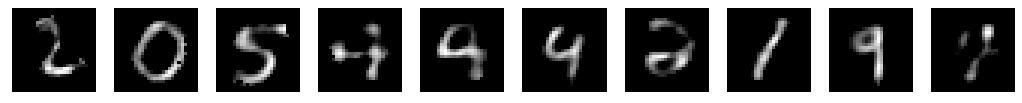

In [0]:
validate_model(auto_encoder, test_x[100:], 10, noise_rate=2)

Noised Images - noise_rate = 1.5


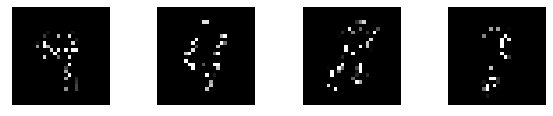


Autoencoder Reconstruction


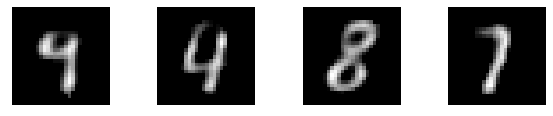

In [0]:
validate_model(auto_encoder, test_x[108:], 4, noise_rate=1.5)

### Conclusion

Based on an intuitive visual validation of the model reconstruction results we can say that the network, although pretty simple, can learn to encode the distribution of data in a smaller dimension that can still be decoded. The second methodology turned out to be more efficient in recovering corrupted images because that is exactly what the model learned, given that corrupted images reconstructed the original images.